<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/En%20Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install shap

In [1]:
import pandas as pd
import numpy as np
#import hyperopt
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

#from pandas.core.common import random_state
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
#import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNN

SEED = 42

In [2]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [3]:
df_original.head()

,Unnamed: 0,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,...,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados,ingreso
0,1,4282.155183,4679.335952,0.000000,0.000000,4923.124484,3918.527125,19692.497937,18439.941778,6653.069810,...,1,0,3,1,0,0,0,63.0,24,31888.466530
1,2,9793.122650,9450.927278,83970.243387,91126.581200,20809.053382,19126.815664,41618.106764,49280.496926,30881.253937,...,0,1,1,1,4,0,2,67.0,24,62341.141710
2,3,531419.701556,512057.084981,0.000000,0.000000,36813.149453,46144.419161,36813.149453,36789.292777,36813.149453,...,2,1,0,3,0,0,0,NaN,24,100599.764680
3,4,0.000000,0.000000,2266.728708,2633.111538,11533.815438,10488.338604,23067.630876,24025.952782,19044.717097,...,4,0,0,4,4,2,3,NaN,24,46102.904895
4,5,112394.057367,110856.020945,0.000000,0.000000,41131.333850,42820.024254,82262.667700,77614.227322,43944.580379,...,4,0,0,4,0,0,0,65.0,14,109419.216020


In [4]:
print (df_original.isnull().sum())

Unnamed: 0                   0
vigente                      0
vigenteAvg3M                 0
vencido                      0
vencidoAvg3M                 0
avgcontingenciaU1M           0
avgcontingenciaU3M           0
sumcontingenciaU1M           0
sumcontingenciaU3M           0
maxcontingenciaU1M           0
maxcontingenciaU3M           0
numcontingenciaU1M           0
garantiacomputable           0
peorcalificacionBCU          0
numeroinstituciones          0
numerobancosprivados         0
numerobancospublicos         0
numerofinancieras            0
numerobancos                 0
numerode5ult18meses          0
numerode2Bult18meses         0
numerode3ult18meses          0
edad                     11429
numeromesesreportados        0
ingreso                      0
dtype: int64


se remplazan los null por la media de la columna

In [5]:
edad_media = df_original['edad'].mean()
edad_media

45.02159532392986

In [6]:
def transfromar_DataFrame (df):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('2B','3').
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  return df

In [7]:
df = transfromar_DataFrame(df_original)


In [8]:
df.head()

,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,maxcontingenciaU3M,...,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados,ingreso
0,4282.155183,4679.335952,0.000000,0.000000,4923.124484,3918.527125,19692.497937,18439.941778,6653.069810,7995.580509,...,1,0,3,1,0,0,0,63.000000,24,31888.466530
1,9793.122650,9450.927278,83970.243387,91126.581200,20809.053382,19126.815664,41618.106764,49280.496926,30881.253937,32793.577625,...,0,1,1,1,4,0,2,67.000000,24,62341.141710
2,531419.701556,512057.084981,0.000000,0.000000,36813.149453,46144.419161,36813.149453,36789.292777,36813.149453,46144.419161,...,2,1,0,3,0,0,0,45.021595,24,100599.764680
3,0.000000,0.000000,2266.728708,2633.111538,11533.815438,10488.338604,23067.630876,24025.952782,19044.717097,17864.388357,...,4,0,0,4,4,2,3,45.021595,24,46102.904895
4,112394.057367,110856.020945,0.000000,0.000000,41131.333850,42820.024254,82262.667700,77614.227322,43944.580379,42820.024254,...,4,0,0,4,0,0,0,65.000000,14,109419.216020


In [9]:
y = df.pop("ingreso")
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [10]:
# La linea base es el promedio de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
media = y_train.mean()
baseline_preds['media'] = media
# Baseline errors, and display average baseline error
baseline_MAPE = MAPE(y_train,baseline_preds['media'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2))

MAPE linea base:  58.03


In [12]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 500, random_state = SEED)
# Train the model on training data
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [13]:
# Use the forest's predict method on the test data
preds_rf = rf.predict(X_test)
# Calculate the absolute percentage errors
MAPE_rf = MAPE(y_test, preds_rf)
# Print out the mean absolute percentageerror (mape)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE_rf: 12.93


Text(0.5, 0, 'Xgboost Feature Importance')

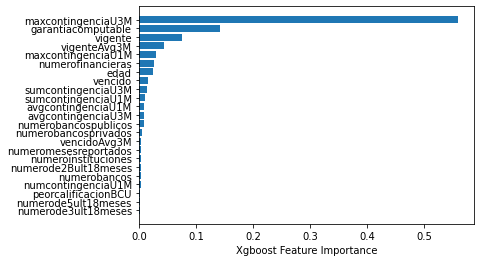

In [14]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), rf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

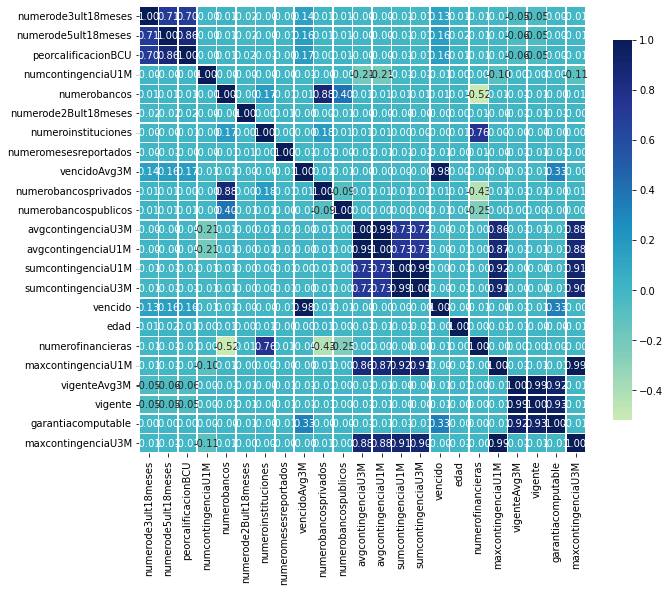

In [15]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[list(X_train.columns[sorted_idx])])

In [16]:
model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="mae",
        tree_method = "gpu_hist",
        n_estimators=1000,
        random_state=SEED,
        max_depth=6,
        booster="gbtree",
        learning_rate=0.01,
        subsample=0.7,
        gamma=0,
        reg_alpha=0,
        reg_lambda=1,
        importance_type="gain",
        colsample_bytree=0.9,
        colsample_bynode=0.8,
        colsample_bylevel=0.8,
        verbosity=1,
        n_jobs=-1,
)

In [17]:
model.fit(X_train,y_train)

XGBRegressor(colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.9,
             eval_metric='mae', learning_rate=0.01, max_depth=6,
             n_estimators=1000, n_jobs=-1, objective='reg:squarederror',
             random_state=42, subsample=0.7, tree_method='gpu_hist')

In [18]:
preds_xgb = model.predict(X_test)
# Calculate the absolute percentage errors
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 13.13


Text(0.5, 0, 'Xgboost Feature Importance')

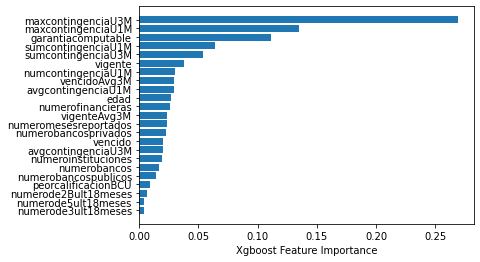

In [19]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

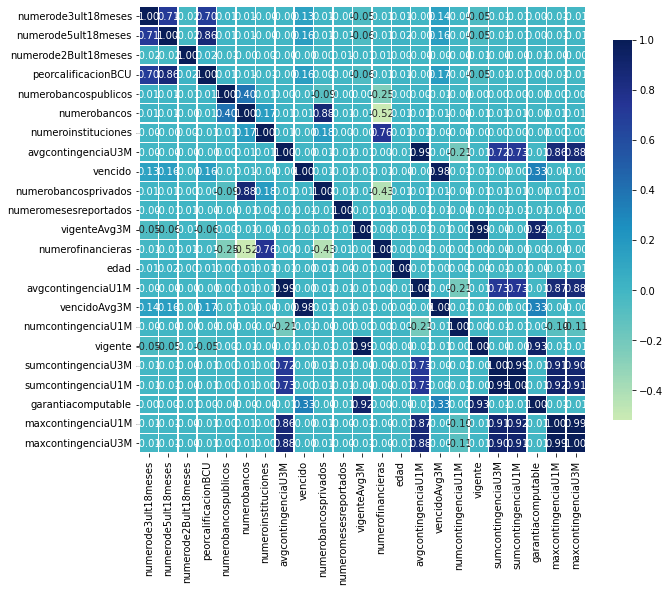

In [20]:
correlation_heatmap(X_train[list(X_train.columns[sorted_idx])])

In [ ]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, plot_type="bar")

Se hace la prueba de una regresión lineal con las columnas más influyentes

In [21]:
X_train_LR = X_train[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]
X_test_LR = X_test[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]

In [22]:
pipe_LR = Pipeline([('scaler',StandardScaler()),('model',LR())])
pipe_LR.fit(X_train_LR,y_train)
preds_LR = pipe_LR.predict(X_test_LR)
MAPE_LR = MAPE(y_test, preds_LR)
print('MAPE_LR:', round(100*MAPE_LR, 2))

MAPE_LR: 19.54


lo mismo con knn

In [25]:
pipe_KNN = Pipeline([('scaler',StandardScaler()),('model',KNN(n_neighbors=50))])
pipe_KNN.fit(X_train_LR,y_train)
preds_KNN = pipe_KNN.predict(X_test_LR)
MAPE_KNN = MAPE(y_test, preds_KNN)
print('MAPE_KNN:', round(100*MAPE_KNN, 2))

MAPE_KNN: 15.58


In [26]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [27]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'mae',
    'tree_method' : 'gpu_hist',
}

In [28]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[00:13:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:47179.6
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:33009.5
[2]	Test-mae:23499.8
[3]	Test-mae:17619.1
[4]	Test-mae:14238.5
[5]	Test-mae:12490.9
[6]	Test-mae:11602
[7]	Test-mae:11150.9
[8]	Test-mae:10971.3
[9]	Test-mae:10836.5
[10]	Test-mae:10703.3
[11]	Test-mae:10600.3
[12]	Test-mae:10571.4
[13]	Test-mae:10530.6
[14]	Test-mae:10490.4
[15]	Test-mae:10409.7
[16]	Test-mae:10361.5
[17]	Test-mae:10350
[18]	Test-mae:10303.9
[19]	Test-mae:10264.7
[20]	Test-mae:10233.4
[21]	Test-mae:10225
[22]	Test-mae:10207.5
[23]	Test-mae:10198.1
[24]	Test-mae:10165.7
[25]	Test-mae:10149.7
[26]	Test-mae:10142.8
[27]	Test-mae:10128.4
[28]	Test-mae:10137.6
[29]	Test-mae:10129.3
[30]	Test-mae:10140.8
[31]	Test-mae:10137.1
[32]	Test-mae:10148.1
[33]	Test-mae:10153.9
[34]	Test-mae:10107.9
[35]	Test-mae:10111.3
[36]	Test-mae:10107.1
[37]	Test-mae:10075

In [ ]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 10029.66 with 49 rounds


In [29]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [30]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=SEED,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
    
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[00:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 10341.4634766 for 26 rounds
CV with max_depth=9, min_child_weight=6
[00:13:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

In [31]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [32]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [33]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=SEED,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )  
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[00:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 10319.5048826 for 31 rounds
CV with subsample=1.0, colsample=0.9
[00:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:

In [ ]:
params['subsample'] = 0.9
params['colsample_bytree'] = 1

In [ ]:

# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))    
    # We update our parameters
    params['eta'] = eta    
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=SEED,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
[19:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 10712.1580078 for 14 rounds

CV with eta=0.2
[19:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:58] WARNING: /workspace/src/objective/

In [34]:
params['eta'] = 0.01

In [ ]:
params

{'colsample_bytree': 0.7,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 0.7,
 'tree_method': 'gpu_hist'}

In [35]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[00:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:66820.5
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:66157
[2]	Test-mae:65496.5
[3]	Test-mae:64842.5
[4]	Test-mae:64196.6
[5]	Test-mae:63555.5
[6]	Test-mae:62922.7
[7]	Test-mae:62296.2
[8]	Test-mae:61674.2
[9]	Test-mae:61059
[10]	Test-mae:60450.6
[11]	Test-mae:59845.1
[12]	Test-mae:59246.8
[13]	Test-mae:58655.6
[14]	Test-mae:58072.2
[15]	Test-mae:57495.4
[16]	Test-mae:56923.1
[17]	Test-mae:56356
[18]	Test-mae:55793.2
[19]	Test-mae:55235.3
[20]	Test-mae:54682.2
[21]	Test-mae:54136
[22]	Test-mae:53599
[23]	Test-mae:53064.4
[24]	Test-mae:52539.3
[25]	Test-mae:52017.2
[26]	Test-mae:51500.3
[27]	Test-mae:50985.5
[28]	Test-mae:50478.8
[29]	Test-mae:49977.5
[30]	Test-mae:49475.5
[31]	Test-mae:48980.6
[32]	Test-mae:48493.7
[33]	Test-mae:48009.6
[34]	Test-mae:47532.6
[35]	Test-mae:47058.2
[36]	Test-mae:46592.8
[37]	Test-mae:46127.8
[

In [36]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[00:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:66820.5
[1]	Test-mae:66157
[2]	Test-mae:65496.5
[3]	Test-mae:64842.5
[4]	Test-mae:64196.6
[5]	Test-mae:63555.5
[6]	Test-mae:62922.7
[7]	Test-mae:62296.2
[8]	Test-mae:61674.2
[9]	Test-mae:61059
[10]	Test-mae:60450.6
[11]	Test-mae:59845.1
[12]	Test-mae:59246.8
[13]	Test-mae:58655.6
[14]	Test-mae:58072.2
[15]	Test-mae:57495.4
[16]	Test-mae:56923.1
[17]	Test-mae:56356
[18]	Test-mae:55793.2
[19]	Test-mae:55235.3
[20]	Test-mae:54682.2
[21]	Test-mae:54136
[22]	Test-mae:53599
[23]	Test-mae:53064.4
[24]	Test-mae:52539.3
[25]	Test-mae:52017.2
[26]	Test-mae:51500.3
[27]	Test-mae:50985.5
[28]	Test-mae:50478.8
[29]	Test-mae:49977.5
[30]	Test-mae:49475.5
[31]	Test-mae:48980.6
[32]	Test-mae:48493.7
[33]	Test-mae:48009.6
[34]	Test-mae:47532.6
[35]	Test-mae:47058.2
[36]	Test-mae:46592.8
[37]	Test-mae:46127.8
[38]	Test-mae:45671.5
[39]	Test-mae:45217.8
[40]	Test-mae

In [37]:
preds_tuned = best_model.predict(dtest)
# Calculate the absolute percentage errors
MAPE_tuned = MAPE(y_test, preds_tuned)
print('MAPE_tuned:', round(100*MAPE_tuned, 2))

MAPE_tuned: 12.8


In [40]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

df_test_original.head()

,Unnamed: 0,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,...,numeroinstituciones,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados
0,40001,10725.957382,11480.961340,0.0,0.0,19510.697566,23402.938295,19510.697566,20719.358643,19510.697566,...,2,0,0,2,0,0,3,0,29.0,24
1,40002,82242.277287,77710.508800,0.0,0.0,13968.618508,14816.095112,27937.237016,23324.599806,17527.530907,...,5,0,1,4,1,0,1,0,66.0,24
2,40003,1646.607555,1836.928522,0.0,0.0,71846.928147,68585.407866,71846.928147,83632.771011,71846.928147,...,2,2,0,0,2,0,4,0,35.0,24
3,40004,8740.977410,8640.764002,0.0,0.0,24560.879097,26136.018124,49121.758195,48865.156174,42492.834450,...,2,1,1,0,2,0,0,0,54.0,24
4,40005,365107.557629,366550.793336,0.0,0.0,13879.429839,11677.655495,27758.859677,28020.443219,23587.864067,...,2,1,1,0,2,0,1,0,NaN,19


In [41]:
df_test = transfromar_DataFrame(df_test_original)


In [42]:
d_test = xgb.DMatrix(df_test)

In [51]:
preds_datathon = best_model.predict(d_test)

In [54]:
pd.DataFrame(preds_datathon).to_csv('predicciones.csv') 